-----------------Config Info-----------------
N: 10
T: 11000
T_train_val: 10000
train_ratio: 0.8
T_train: 8000
T_val: 2000
T_test: 1000
data_type: ar1
batch_size: 64
seq_length: 20
input_size: 10
output_size: 10
learning_rate: 0.001
num_epochs: 100
num_workers: 24
device: cuda
mix_precision: True
patience_epochs: 6
min_delta: 0.01
mode: min
factor: 0.1
patience_lr: 2
min_lr: 1e-06
threshold: 0.01
dg_config:
    mean_load: 50.0
    var_load: 10.0
    iid_var: 1.0
    theta: 0.9
ar_config:
    order: 5
lstm_config:
    hidden_size: 64
    num_layers: 4
gat_config:
    hidden_size: 32
    num_heads: 8
    num_gat_layers: 3
gnn_config: GNNConfig(hidden_size=32, num_layers=3)
-----------------Train and Valid Info-----------------
load_iid.shape: (10, 11000)
load_ar1.shape: (10, 11000)
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
train_data_np.shape: (10, 8000)
val_data_np.shape: (10,

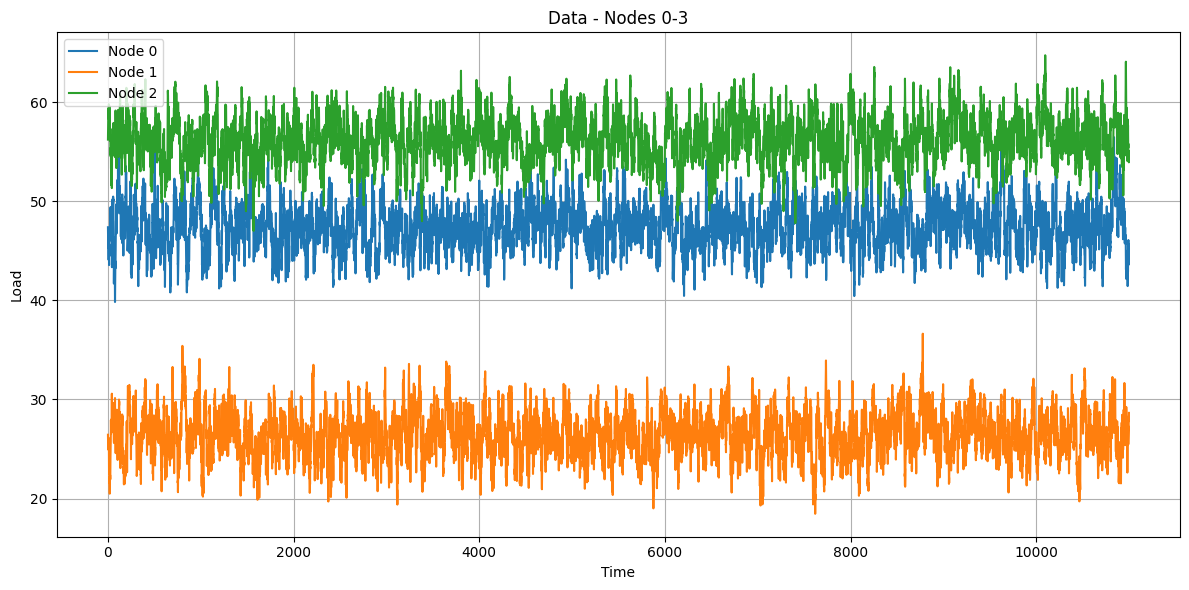

In [1]:
import torch
from Config_Data import DataGenerateConfig, ARConfig, LSTMConfig, GATConfig, GNNConfig, Process

current_config = {
    'N': 10,
    'T': 11000,
    'T_train_val': 10000,
    'T_test': 1000,
    'train_ratio': 0.8,
    'T_train': 8000,
    'T_val': 2000,
    'data_type': 'ar1',

    'batch_size': 64,
    'seq_length': 20,
    'input_size': 10,
    'output_size': 10,
    'learning_rate': 0.001,
    'num_epochs': 100,
    'num_workers': 24,
    'device': 'cuda',

    'patience_epochs': 6,
    'min_delta': 1e-2,

    'mode': 'min',
    'factor': 0.1,
    'patience_lr': 2,
    'min_lr': 1e-6,
    'threshold': 1e-2,

    'dg_config': DataGenerateConfig(mean_load=50.0, var_load=10.0, iid_var=1.0, theta=0.9),
    'ar_config': ARConfig(order=5),
    'lstm_config': LSTMConfig(hidden_size=64, num_layers=4),
    'gat_config': GATConfig(hidden_size=32, num_heads=8, num_gat_layers=3),
    'gnn_config': GNNConfig(hidden_size=32, num_layers=3)
}
# config, data_generate, data_train_val_manage = main(RE_GENERATE_DATA=True, **current_config)

config, data_manage = Process(RE_GENERATE_DATA=False, **current_config)

In [16]:
data = data_manage.data_np
data.shape


(10, 11000)

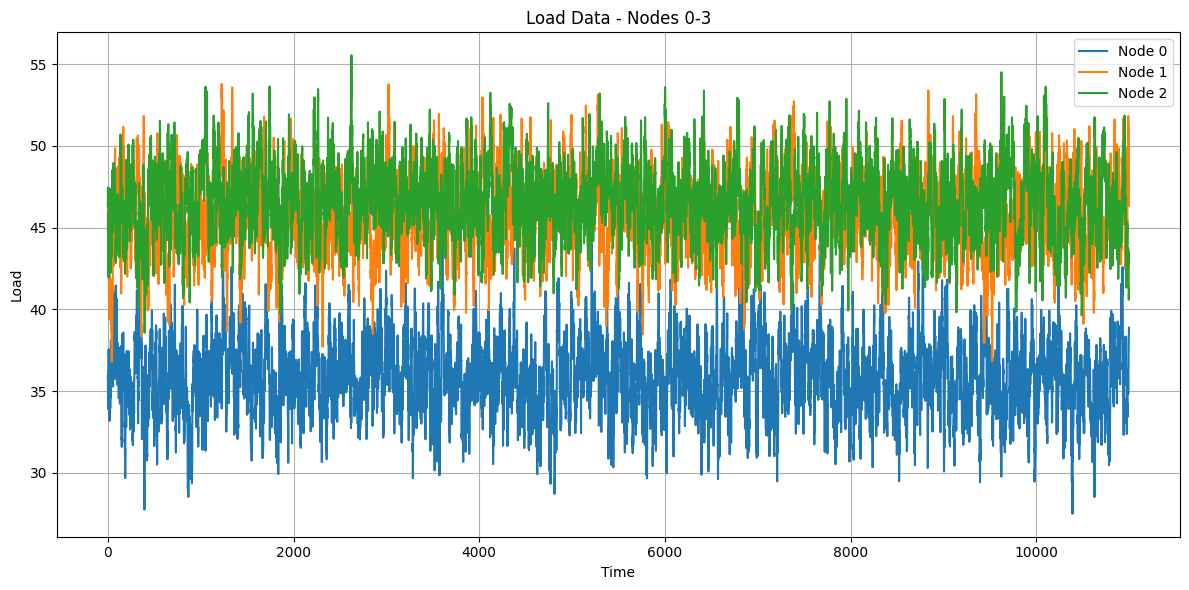

In [17]:
data_manage.plot_range_data(data[:3, :], start=0, end=len(data[0]), title='Load Data')

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

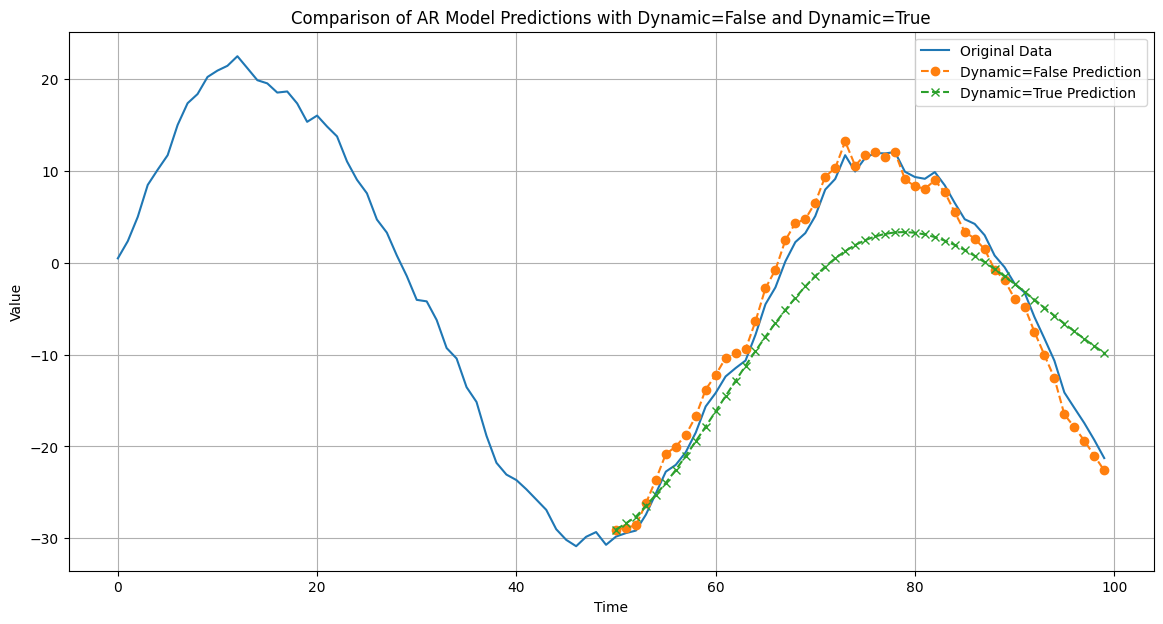

In [19]:
# 生成示例数据
np.random.seed(42)
n = 100
time_series_data = np.cumsum(np.random.randn(n)) + 20 * np.sin(np.linspace(0, 10, n))

# 拟合 AutoReg 模型
order = 5
model = AutoReg(time_series_data, lags=order, hold_back=order).fit()

# 预测未来 20 个时间点，dynamic=False 和 dynamic=True 的对比
forecast_steps = 50
pred_dynamic_false = model.predict(start=n - forecast_steps + 1, end=n, dynamic=False)
pred_dynamic_true = model.predict(start=n - forecast_steps + 1, end=n, dynamic=True)

# 绘制结果对比
plt.figure(figsize=(14, 7))

# 绘制真实数据
plt.plot(np.arange(n), time_series_data, label='Original Data')

# 绘制 dynamic=False 的预测结果
plt.plot(np.arange(n - forecast_steps, n), pred_dynamic_false, label='Dynamic=False Prediction', linestyle='--',
         marker='o')

# 绘制 dynamic=True 的预测结果
plt.plot(np.arange(n - forecast_steps, n), pred_dynamic_true, label='Dynamic=True Prediction', linestyle='--',
         marker='x')

plt.title('Comparison of AR Model Predictions with Dynamic=False and Dynamic=True')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# class ARExpert:
#     """
#     AR专家，每次预测后都会使用全部的历史数据（而不是移动窗口）更新模型，然后再进行预测
#     
#     参数:
#     - data: ndarray, 每行代表一个节点的负载数据， shape 为 (N, T_train + T_test)
#     - order: int, AR模型的阶数
#     """
# 
#     def __init__(self, data, order=5, T_train=10000, T_test=1000):
#         self.N = data.shape[0]
#         self.data = data
#         self.order = order  # AR 模型的阶数
# 
#         self.len_train = T_train
#         self.len_test = T_test
# 
#         self.train_data = data[:, :self.len_train]  # 训练数据 (N, T_train)
#         self.test_data = data[:, self.len_train:]  # 测试数据，形状为 (N, T_test)
# 
#         # 预先分配 joint_train_data 的空间
#         self.joint_train_data = np.zeros((self.N, self.len_train + self.len_test))
#         self.joint_train_data[:, :self.len_train] = self.train_data
# 
#         self.models = [AutoReg(self.joint_train_data[i, :self.len_train], lags=order).fit() for i in
#                        range(self.N)]  # 初始化模型
# 
#         self.predictions = np.zeros((self.N, self.len_test))  # 存储每次的预测结果
#         self.true_values = np.zeros((self.N, self.len_test))  # 存储每次的真实数据
#         self.losses = np.zeros((self.N, self.len_test))  # 存储每次的损失
# 
#     def predict_and_update(self):
# 
#         for t in range(self.len_test):
#             print(f't={t}, joint_train_data.shape={self.joint_train_data.shape}')
# 
#             # 预测
#             predictions = [self.models[i].predict(start=self.len_train + t, end=self.len_train + t) for i in
#                            range(self.N)]
#             self.predictions[:, t] = np.array(predictions).flatten()
# 
#             if t < self.len_test - 1:
#                 # 获取真实值并更新 joint_train_data
#                 self.true_values[:, t] = self.test_data[:, t]
#                 self.joint_train_data[:, self.len_train + t] = self.true_values[:, t]
# 
#                 # 更新所有节点的模型
#                 self.models = [AutoReg(self.joint_train_data[i, :self.len_train + t + 1], lags=self.order).fit() for i
#                                in range(self.N)]
# 
#             else:
#                 self.true_values[:, t] = self.test_data[:, t]
# 
#         self.losses = self.compute_loss(np.array(self.predictions), np.array(self.true_values))
#         return self.predictions, self.true_values, self.losses
# 
#     def compute_loss(self, predictions, true_values):
#         return np.mean((predictions - true_values) ** 2, axis=0)
# 
#     def get_predictions(self):
#         return self.predictions
# 
#     def get_true_values(self):
#         return self.true_values
# 
#     def get_losses(self):
#         return self.losses
# 
#     def plot_losses(self):
#         plt.figure(figsize=(10, 6))
#         plt.plot(self.losses, label='Loss')
#         plt.title('Prediction Loss over Time')
#         plt.xlabel('Time Step')
#         plt.ylabel('Mean Squared Error')
#         plt.legend()
#         plt.grid(True)
#         plt.show()
# 
#     def plot_predictions(self, node_index, start=0, end=11000):
#         plt.figure(figsize=(10, 6))
# 
#         # 绘制真实数据
#         if start < self.len_train:
#             plt.plot(range(start, min(end, self.len_train)),
#                      self.train_data[node_index][start:min(end, self.len_train)], label='True Data (Train)')
#         if end > self.len_train:
#             plt.plot(range(max(start, self.len_train), end),
#                      self.test_data[node_index][max(0, start - self.len_train):end - self.len_train],
#                      label='True Data (Test)')
# 
#         # 绘制预测数据
#         plt.plot(range(max(self.len_train, start), min(end, self.len_train + self.len_test)),
#                  self.predictions[node_index][max(0, start - self.len_train):min(end - self.len_train, self.len_test)],
#                  label='Predictions', linestyle='--')
# 
#         plt.title(f'Predictions for Node {node_index}')
#         plt.xlabel('Time Step')
#         plt.ylabel('Load')
#         plt.legend()
#         plt.grid(True)
#         plt.show()

In [21]:
class ARExpert:
    """
    AR专家，每次预测后都会使用全部的历史数据（而不是移动窗口）更新模型，然后再进行预测
    
    参数:
    - data: ndarray, 每行代表一个节点的负载数据， shape 为 (N, T_train + T_test)
    - order: int, AR模型的阶数
    """

    def __init__(self, config, data_manage):
        self.config = config
        self.data_manage = data_manage

        # 
        # self.N = data.shape[0]
        # self.data = data
        # self.order = order  # AR 模型的阶数
        # 
        # self.len_train = T_train
        # self.len_test = T_test
        # 
        # self.train_data = data[:, :self.len_train]  # 训练数据 (N, T_train)
        # self.test_data = data[:, self.len_train:]  # 测试数据，形状为 (N, T_test)

        # 预先分配 joint_train_data 的空间
        self.joint_train_data = np.zeros((self.config.N, self.config.T_train_val + self.config.T_test))
        # 将训练验证数据填充到 joint_train_data 中
        self.joint_train_data[:, :self.config.T_train_val] = self.data_manage.train_val_data

        # 为每个节点训练一个 AR 模型
        self.models = [
            AutoReg(self.joint_train_data[i, :self.config.T_train_val], lags=self.config.ar_config.order).fit() for i in
            range(self.config.N)]

        self.predictions = np.zeros((self.config.N, self.config.T_test))  # 存储每次的预测结果
        self.true_values = np.zeros((self.config.N, self.config.T_test))  # 存储每次的真实数据
        self.losses = np.zeros((self.config.N, self.config.T_test))  # 存储每次的损失

    def predict_and_update(self):

        for t in range(self.config.T_test):
            print(f't={t}, joint_train_data.shape={self.joint_train_data.shape}')

            # 预测
            predictions = [self.models[i].predict(start=self.config.T_train_val + t, end=self.config.T_train_val + t)
                           for i in range(self.config.N)]
            self.predictions[:, t] = np.array(predictions).flatten()

            if t < self.config.T_test - 1:
                # 获取真实值并更新 joint_train_data
                self.true_values[:, t] = self.data_manage.test_data[:, t]
                self.joint_train_data[:, self.config.T_train_val + t] = self.true_values[:, t]

                # 更新所有节点的模型
                self.models = [AutoReg(self.joint_train_data[i, :self.config.T_train_val + t + 1],
                                       lags=self.config.ar_config.order).fit() for i in range(self.config.N)]

            else:
                self.true_values[:, t] = self.data_manage.test_data[:, t]

        self.losses = self.compute_loss(np.array(self.predictions), np.array(self.true_values))
        return self.predictions, self.true_values, self.losses

    def compute_loss(self, predictions, true_values):
        return np.mean((predictions - true_values) ** 2, axis=0)

    def get_predictions(self):
        return self.predictions

    def get_true_values(self):
        return self.true_values

    def get_losses(self):
        return self.losses

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses, label='Loss')
        plt.title('Prediction Loss over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Mean Squared Error')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_predictions(self, node_index, start=0, end=11000):
        plt.figure(figsize=(10, 6))

        # 绘制真实数据
        if start < self.config.T_train_val:
            plt.plot(range(start, min(end, self.config.T_train_val)),
                     self.data_manage.train_val_data[node_index][start:min(end, self.config.T_train_val)],
                     label='True Data (Train)')
        if end > self.config.T_train_val:
            plt.plot(range(max(start, self.config.T_train_val), end), self.data_manage.test_data[node_index][max(0,
                                                                                                                 start - self.config.T_train_val):end - self.config.T_train_val],
                     label='True Data (Test)')

        # 绘制预测数据
        plt.plot(range(max(self.config.T_train_val, start), min(end, self.config.T_train_val + self.config.T_test)),
                 self.predictions[node_index][
                 max(0, start - self.config.T_train_val):min(end - self.config.T_train_val, self.config.T_test)],
                 label='Predictions', linestyle='--')

        plt.title(f'Predictions for Node {node_index}')
        plt.xlabel('Time Step')
        plt.ylabel('Load')
        plt.legend()
        plt.grid(True)
        plt.show()

In [22]:
%%time
# 创建 ARExpert 对象并执行预测与更新
ar_expert = ARExpert(config, data_manage)
predictions, true_values, losses = ar_expert.predict_and_update()
losses.sum()

t=0, joint_train_data.shape=(10, 11000)
t=1, joint_train_data.shape=(10, 11000)
t=2, joint_train_data.shape=(10, 11000)
t=3, joint_train_data.shape=(10, 11000)
t=4, joint_train_data.shape=(10, 11000)
t=5, joint_train_data.shape=(10, 11000)
t=6, joint_train_data.shape=(10, 11000)
t=7, joint_train_data.shape=(10, 11000)
t=8, joint_train_data.shape=(10, 11000)
t=9, joint_train_data.shape=(10, 11000)
t=10, joint_train_data.shape=(10, 11000)
t=11, joint_train_data.shape=(10, 11000)
t=12, joint_train_data.shape=(10, 11000)
t=13, joint_train_data.shape=(10, 11000)
t=14, joint_train_data.shape=(10, 11000)
t=15, joint_train_data.shape=(10, 11000)
t=16, joint_train_data.shape=(10, 11000)
t=17, joint_train_data.shape=(10, 11000)
t=18, joint_train_data.shape=(10, 11000)
t=19, joint_train_data.shape=(10, 11000)
t=20, joint_train_data.shape=(10, 11000)
t=21, joint_train_data.shape=(10, 11000)
t=22, joint_train_data.shape=(10, 11000)
t=23, joint_train_data.shape=(10, 11000)
t=24, joint_train_data.sha

1004.4873319043372

In [23]:
ar_expert.get_predictions().shape

(10, 1000)

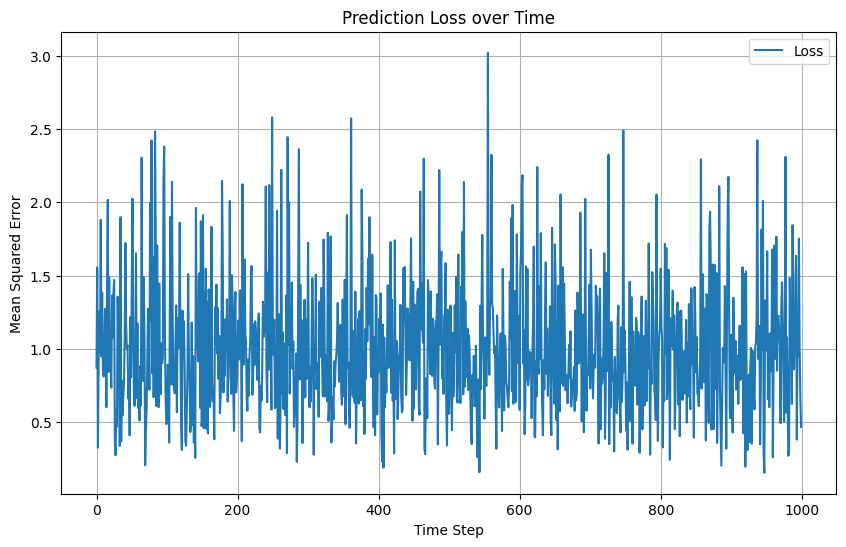

In [24]:
# 绘制损失
ar_expert.plot_losses()

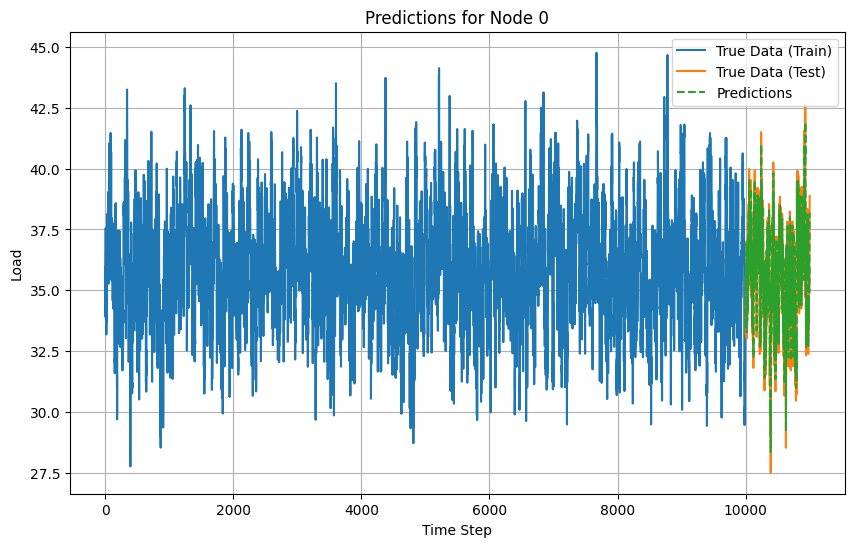

In [25]:
# 绘制预测结果
ar_expert.plot_predictions(node_index=0)


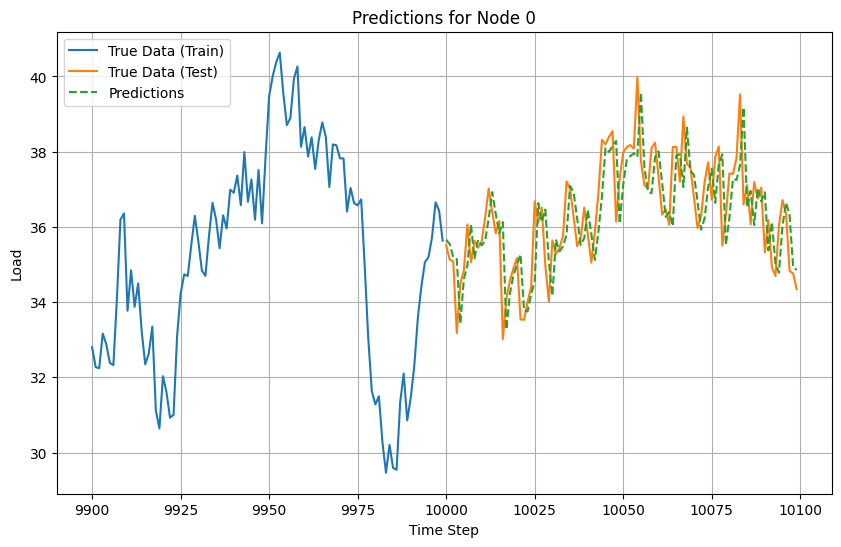

In [26]:
ar_expert.plot_predictions(node_index=0, start=9900, end=10100)

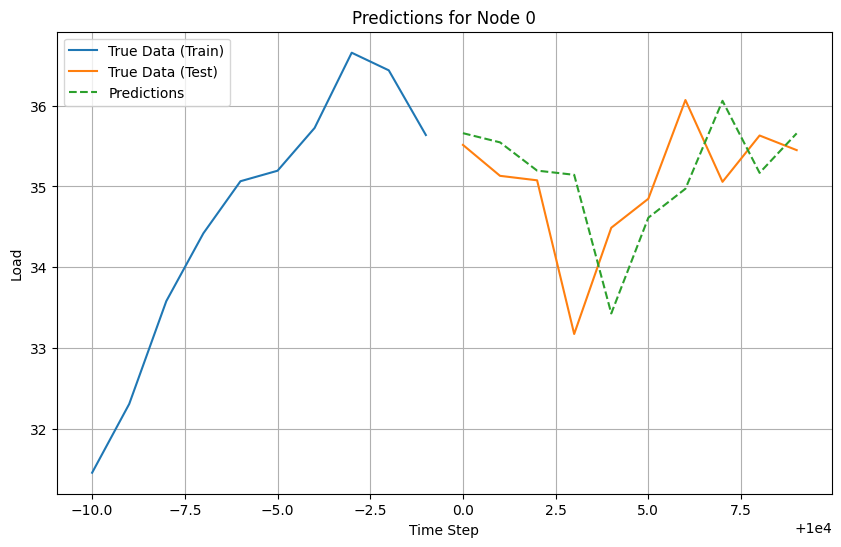

In [27]:
ar_expert.plot_predictions(node_index=0, start=9990, end=10010)

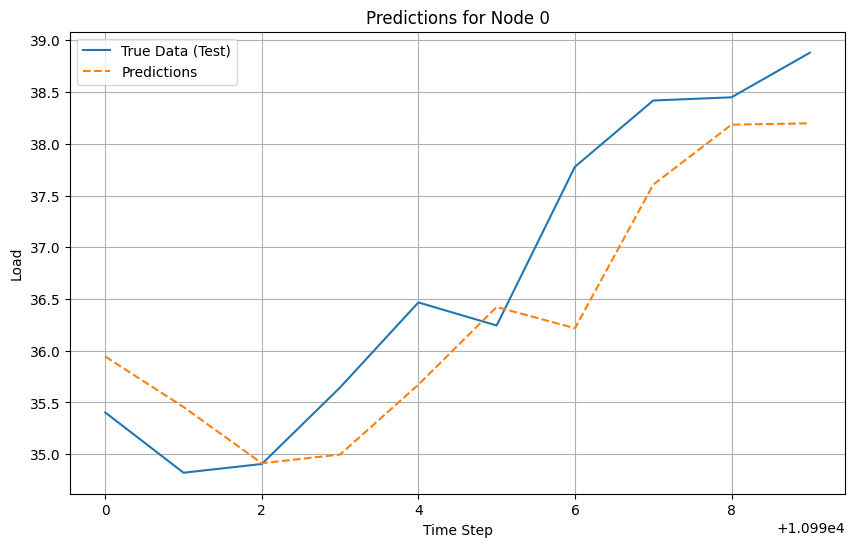

In [28]:
ar_expert.plot_predictions(node_index=0, start=10990, end=11000)

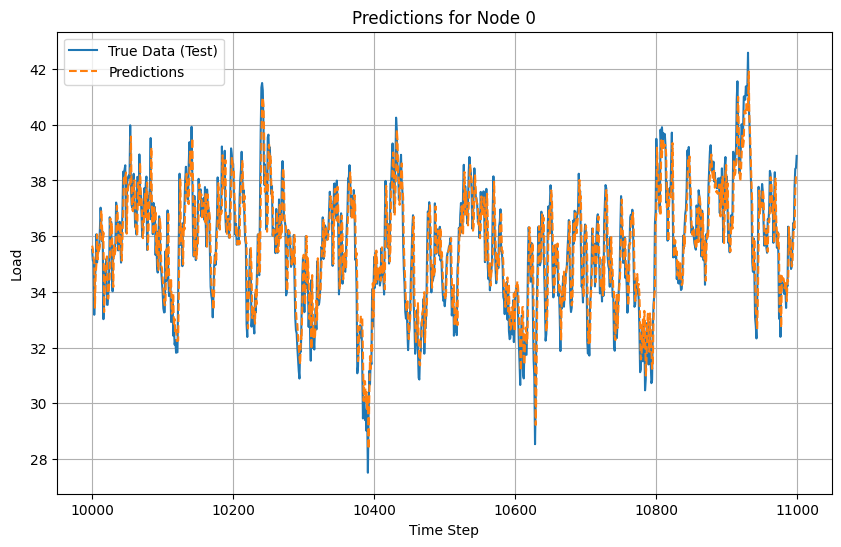

In [29]:
ar_expert.plot_predictions(node_index=0, start=10000, end=11000)